# Importações e funções auxiliares

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygame
import seaborn as sns
import random
from collections import defaultdict

# our classes
from agentLFA import AgentLFA, QLearningAgentLFA, MonteCarloAgentLFA
from environment import Environment
from screen import Screen

# define environment
ACTION_SPACE = np.eye(3)
NUM_ACTIONS = 3
NUM_STATES = 2 ** 11

# Set options to activate or deactivate the game view, and its speed
pygame.font.init()

def plot_metrics(metrics, filepath=None):
    formatted_dict = {'episodes': [],
                      'metrics': [],
                      'results': []}

    n = len(metrics['episodes'])
    for i in range(n):
        episode = metrics['episodes'][i]
        score = metrics['scores'][i]
        reward = metrics['rewards'][i]

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('score')
        formatted_dict['results'].append(score)

        formatted_dict['episodes'].append(episode)
        formatted_dict['metrics'].append('reward')
        formatted_dict['results'].append(reward)

    df_metrics = pd.DataFrame(formatted_dict)
    sns.lineplot(data=df_metrics, x='episodes', y='results', hue='metrics')
    if filepath is None:
        plt.show()
    else:
        plt.savefig(filepath)


def decode_state(encoded_state):
    """
    Decode a binary representation of a state into its decimal base;
    
    encoded_state: an array of 0s and 1s representing a binary value
    
    return: decimal value
    """
    decoded = ''
    for s in encoded_state:
        decoded += str(s)

    return int(decoded, 2)

def decode_action(encoded_action):
    if isinstance(encoded_action, np.ndarray):
        return encoded_action.argmax()
    return encoded_action

def default_reward(env):
    """
    Return the reward.
    The reward is:
        -10 when Snake crashes.
        +10 when Snake eats food
        0 otherwise
    """
    reward = 0
    if env.game.crash:
        reward = -10
    elif env.player.eaten:
        reward = 10

    return reward

from scipy.spatial import distance

def reward_euclidean(env):
    player_pos = [env.player.x, env.player.y]
    food_pos = [env.food.x_food, env.food.y_food]
    dist = distance.euclidean(player_pos, food_pos)
    reward = 0
    if env.game.crash:
        reward = -10000
    elif env.player.eaten:
        reward = 10000
    else:
        if dist > 100:
            reward = (-1*dist)/10
        if dist <= 100:
            reward = (100-dist)/10

    return reward

pygame 2.0.1 (SDL 2.0.14, Python 3.9.0)
Hello from the pygame community. https://www.pygame.org/contribute.html




# Monte Carlo

Game 1      Score: 0
Game 2      Score: 1
Game 3      Score: 1
Game 4      Score: 0
Game 5      Score: 0
Game 6      Score: 1
Game 7      Score: 1
Game 8      Score: 0
Game 9      Score: 0
Game 10      Score: 0
Game 11      Score: 0
Game 12      Score: 0
Game 13      Score: 1
Game 14      Score: 0
Game 15      Score: 0
Game 16      Score: 0
Game 17      Score: 0
Game 18      Score: 1
Game 19      Score: 0
Game 20      Score: 1
Game 21      Score: 1
Game 22      Score: 0
Game 23      Score: 1
Game 24      Score: 0
Game 25      Score: 2
Game 26      Score: 2
Game 27      Score: 0
Game 28      Score: 0
Game 29      Score: 1
Game 30      Score: 0
Game 31      Score: 1
Game 32      Score: 3
Game 33      Score: 1
Game 34      Score: 1
Game 35      Score: 1
Game 36      Score: 2
Game 37      Score: 1
Game 38      Score: 2
Game 39      Score: 4
Game 40      Score: 0
Game 41      Score: 1
Game 42      Score: 1
Game 43      Score: 1
Game 44      Score: 1
Game 45      Score: 2
Game 46      Score:

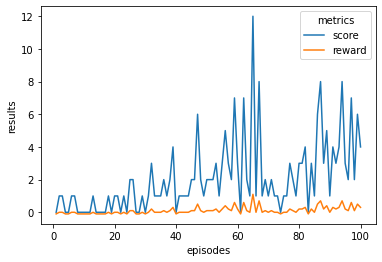

Run time: 78.33008003234863 seconds
Max. Score: 12
Mean Last Scores: 3.16


In [3]:
def run_monte_carlo(agent: AgentLFA, reward_function, episodes, display, speed, verbose=True, first_visit=False):
    # setting random seed
    random.seed(42)
    np.random.seed(42)

    if display:
        pygame.init()

    env = Environment(440, 440, reward_function)
    screen = Screen(env)

    episode = 0
    metrics = {'episodes': [],
               'scores': [],
               'rewards': []}

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    start = time.time()
    while episode < episodes:
        states_and_actions_visited = []

        if display:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()

            screen.display()

        state1, done = env.reset()
        #state1 = decode_state(state1)
        action1 = agent.choose_action(state1)
        episode_reward = 0
        while not done:
            # Getting the next state, reward
            state2, reward, done = env.step(action1)
            #state2 = decode_state(state2)
            # Choosing the next action
            action2 = agent.choose_action(state2)

            # Learning the Q-value
            #decoded_action1 = decode_action(action1)
            #decoded_action2 = decode_action(action2)
            #agent.update(state1, state2, reward, decoded_action1, decoded_action2)

            state1 = state2
            action1 = action2
            episode_reward += reward

            if display:
                screen.display()
                pygame.time.wait(speed)

            states_and_actions_visited.append((state2, action2, reward))

            end = time.time()
            diff = end - start
            if diff > 600: # 10min
                break

        # Acabou o episódio, hora de aprender
        G = 0
        for i, step in enumerate(states_and_actions_visited[::-1]):
            state, action, r = step
            G = agent.gamma*G + r

            do_update = True

            if first_visit:
                if state in [x[0] for x in states_and_actions_visited[::-1][len(states_and_actions_visited)-i:]]:
                    do_update = False

            if do_update:
                sa_pair = (decode_state(step[0]), decode_action(step[1]))

                if sa_pair in returns_sum:
                    returns_sum[sa_pair] += G
                else:
                    returns_sum[sa_pair] = G

                if sa_pair in returns_count:
                    returns_count[sa_pair] += 1.0
                else:
                    returns_count[sa_pair] = 1

                average = returns_sum[sa_pair] / returns_count[sa_pair]
                agent.update(average, state, sa_pair[1])


        # Incrementar episódios e ir guardando as nossas métricas
        episode += 1
        if verbose:
            print(f'Game {episode}      Score: {env.game.score}')

        mean_reward = episode_reward/episodes
        metrics['episodes'].append(episode)
        metrics['rewards'].append(mean_reward)
        metrics['scores'].append(env.game.score)

        end = time.time()
        diff = end - start
        if diff > 600: # 10min
            break


    return metrics

N0 = 1
gamma = 1

# define agent
monteCarloAgent = MonteCarloAgentLFA(N0, gamma, NUM_STATES, NUM_ACTIONS, ACTION_SPACE)

start = time.time()
metrics = run_monte_carlo(monteCarloAgent, reward_function=default_reward, episodes=100, speed=0, display=True)
end = time.time()

plot_metrics(metrics, filepath=None)
print('Run time:', (end-start), 'seconds')
print('Max. Score:', max(metrics['scores']))
print('Mean Last Scores:', np.mean(metrics['scores'][-50:]))